In [2]:
using Plots; GR.init() #plotlyjs()
using Random, Distributions
import Statistics as st
import StatsBase as sb
import LinearAlgebra as la
using LaTeXStrings
using OrdinaryDiffEq, ModelingToolkit, DiffEqOperators


In [3]:
k = 0.938
C_0 = 2.1
B=(1.5*C_0)
bc_k=0.3
height_domain =0.01
length_domain =0.05
dt=0.001
nt=200
T=dt*nt
D(om_mean)=2*C_0*k/((B^2)*om_mean)

nknots = 100
h = height_domain/(nknots-1)
knots = range(0, step=h, length=nknots)
ord_deriv = 2
ord_approx = 2

#data from file setup
n=10
psi_partions_num = 50
phi_domain = [0,1.2]
Del_phi = (phi_domain[2]-phi_domain[1])/psi_partions_num
Del_phi_x_phi = (Del_phi)^2 
x_res=n*5 #number of cells in x dim
y_res=n
t_space = LinRange(0,T,nt+1)
# x_space = LinRange(0,length_domain,x_res)
y_space = LinRange(0,height_domain,y_res+1)
length_domain = 0.20 #length of periodic element
height_domain = 0.01
psi_spacing = LinRange(0,1.2,psi_partions_num+1) #defines boundaries for cells in psi space
psi_spacing = 0.5 .* (psi_spacing[1:psi_partions_num]+psi_spacing[2:psi_partions_num+1])#defining centres of bins

base_filename="Data/paper/PSP_off_uniform_1_10x50_005_001_c_0_21_k_0938_w_varied_new_abs_Inf_vp_psi50_2000resparts_bck_03_dt0001"
omega_means = [0.5,1]
append!(omega_means,2.5:2.5:25)
edge_difference=zeros(length(omega_means),nt+1, nknots)
for (loop,omega_mean)=enumerate(omega_means)
    #FDM
    Δ = (D(omega_mean))*CenteredDifference(ord_deriv, ord_approx, h, nknots)
    bc = RobinBC((-bc_k,D(omega_mean),0.0),(0.0,D(omega_mean),0.0), h, ord_approx)

    t0 = 0.0
    t1 = T
    u0 = ones(nknots) #.*(knots.<0.5*height_domain)#u_analytic.(knots, t0)
    step(u,p,t) = Δ*bc*u
    prob = ODEProblem(step, u0, (t0, t1),reltol=1e-12, abstol=1e-12)
    alg = RadauIIA5()
    sol = solve(prob, alg)

    #from file
    in_data=zeros(psi_partions_num, psi_partions_num, y_res, x_res, nt+1)
    filename = base_filename*"/omega"*string(omega_mean)
    read!(filename,in_data)
    phi_1_means = [sum([sum(in_data[:,psi_2_index,i,j,t].*psi_spacing ) for psi_2_index in 1:psi_partions_num]) for i in 1:y_res, j in 1:x_res, t in 1:nt+1]
    x_integral_means = sum(phi_1_means, dims=2)[:,1,:] .* 1/x_res

    edge_difference[loop,:,:] = [sol(t_space[i])[j]-x_integral_means[ceil(Int, j*y_res/nknots),i] for i in 1:length(t_space), j in 1:nknots]
end

┌ Warning: #= /home/u2093579/.julia/packages/DiffEqOperators/lqggZ/src/derivative_operators/convolutions.jl:375 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ DiffEqOperators /home/u2093579/.julia/packages/LoopVectorization/ndGJi/src/condense_loopset.jl:825
┌ Warning: #= /home/u2093579/.julia/packages/DiffEqOperators/lqggZ/src/derivative_operators/convolutions.jl:419 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ DiffEqOperators /home/u2093579/.julia/packages/LoopVectorization/ndGJi/src/condense_loopset.jl:825


┌ Warning: #= /home/u2093579/.julia/packages/DiffEqOperators/lqggZ/src/derivative_operators/convolutions.jl:392 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ DiffEqOperators /home/u2093579/.julia/packages/LoopVectorization/ndGJi/src/condense_loopset.jl:825
┌ Warning: #= /home/u2093579/.julia/packages/DiffEqOperators/lqggZ/src/derivative_operators/convolutions.jl:356 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ DiffEqOperators /home/u2093579/.julia/packages/LoopVectorization/ndGJi/src/condense_loopset.jl:825


┌ Warning: #= /home/u2093579/.julia/packages/DiffEqOperators/lqggZ/src/derivative_operators/convolutions.jl:415 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ DiffEqOperators /home/u2093579/.julia/packages/LoopVectorization/ndGJi/src/condense_loopset.jl:825


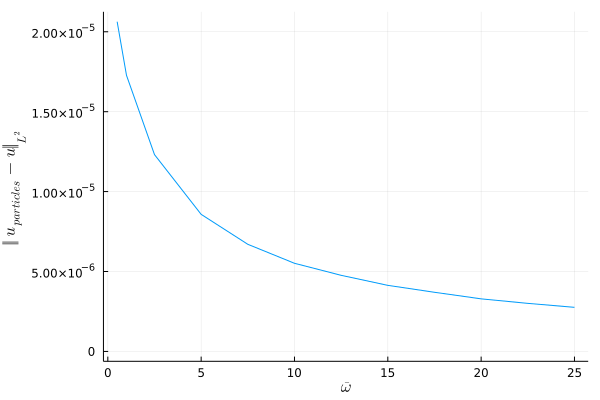

In [4]:
u_error = sum((edge_difference.^2) .*(height_domain/nknots).*(T/(nt+1)),dims=[2,3])[:,1,1]
plt1=plot((omega_means), (u_error),
# title="Error in Mixing Free Boundary Condition" ,
ylabel=L"\Vert u_{particles}-u \Vert_{L^2}",
xlabel=L"\bar{\omega}",
ylims=[0,maximum(u_error)],
legend=false)
display(plt1)
savefig(plt1,"error_plot.png")

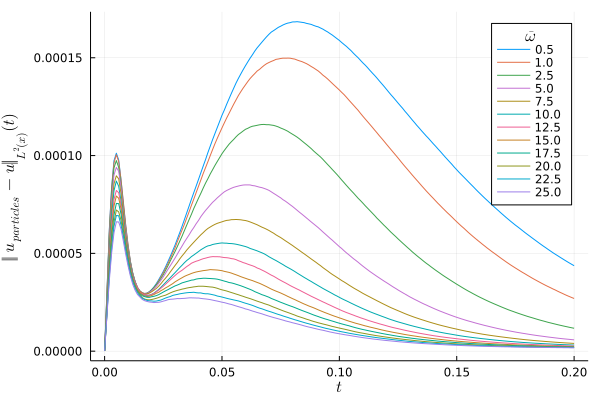

In [5]:
plt2=plot(legend_title=L"\bar{\omega}")
for i in 1:length(omega_means)
    plot!(plt2, t_space,sum(edge_difference[i,:,:].^2 .*(height_domain/nknots),dims=2)[:,1],
    # title="Error in Mixing Free Boundary Condition" ,
    ylabel=L"\Vert u_{particles}-u \Vert_{L^2(x)}(t)",
    xlabel=L"t",
    label=omega_means[i])
end
display(plt2)
savefig(plt2,"error_plot_2.png")

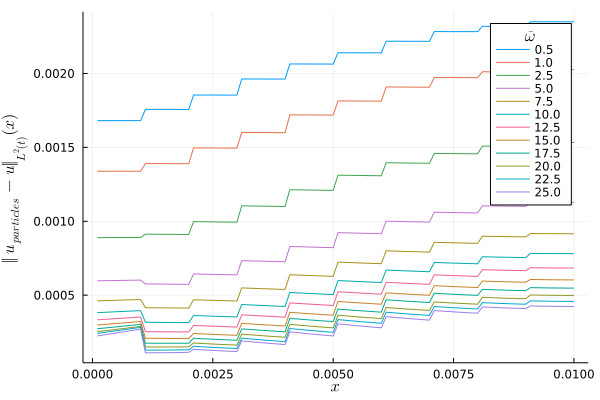

In [6]:
plt3=plot(legend_title=L"\bar{\omega}")
for i in 1:length(omega_means)
    plot!(plt3, (1:nknots).*(height_domain/nknots),
    sum(edge_difference[i,:,:].^2 .*(T/(nt+1)),dims=1)[1,:],
    # title="Error in Mixing Free Boundary Condition" ,
    ylabel=L"\Vert u_{particles}-u \Vert_{L^2(t)}(x)",
    xlabel=L"x",
    label=omega_means[i])
end
display(plt3)
savefig(plt3,"error_plot_3.png")

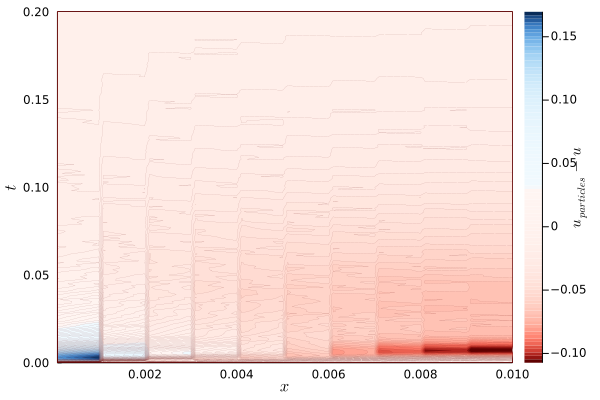

In [7]:
plt4 = contour(
(1:nknots).*(height_domain/nknots),
t_space,
edge_difference[end,:,:],
levels=100, 
color= colormap("RdBu", logscale=true),
xlabel=L"x",
ylabel=L"t",
colorbartitle=L"u_{particles}-u",
fill=true,
line=false)
display(plt4)
savefig(plt4,"error_plot_4.png")


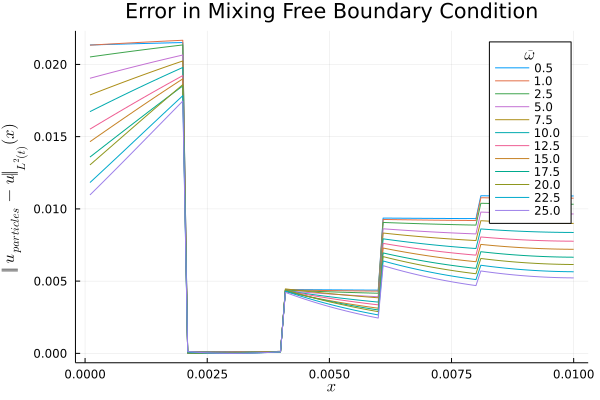

In [41]:
plt5=plot(legend_title=L"\bar{\omega}")
for i in 1:length(omega_means)
    plot!(plt5, (1:nknots).*(height_domain/nknots),
    edge_difference[i,5,:].^2,
    title="Error in Mixing Free Boundary Condition" ,
    ylabel=L"\Vert u_{particles}-u \Vert_{L^2(t)}(x)",
    xlabel=L"x",
    label=omega_means[i])
end
display(plt5)